In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Single-Cell Data

In [5]:
data_dir = './data'

single_adata = sc.read(os.path.join(data_dir,'single.filtered.updated.h5ad'))

Only considering the two last: ['.updated', '.h5ad'].
Only considering the two last: ['.updated', '.h5ad'].


## Exploring Achilles

In [ ]:
data_dir = './data/achilles'

sample_info = pd.read_csv(os.path.join(data_dir,'sample_info.csv'))
id2name = {depmapid: ccle_name for depmapid,ccle_name in sample_info[['DepMap_ID','CCLE_Name']].values}

mutation_df = pd.read_csv(os.path.join(data_dir,'CCLE_mutations.csv'))
mutation_df = mutation_df[mutation_df['isDeleterious'].values.astype(str) != 'nan']
mutation_df = mutation_df[mutation_df['isDeleterious'].values]

mutation_df['CCLE_Name'] = [id2name[n] for n in mutation_df['DepMap_ID'].values]

cell_line_mutation_dict = {}
for gene,cell_line in mutation_df[['Hugo_Symbol','CCLE_Name']].values:
    if cell_line not in cell_line_mutation_dict:
        cell_line_mutation_dict[cell_line] = []
    cell_line_mutation_dict[cell_line].append(gene)
    
# exclude multiples of a gene
cell_line_mutation_dict = {k: list(set(v)) for k,v in cell_line_mutation_dict.items()}

In [7]:
cat1 = ['SMARCB1','SMARCA4','ARID1A','SMARCE1']
cat2 = ['ARID2','BRD7','PBRM1']
cat3 = ['BRD9','SMARCD1'] #,'GLTSCR1']
cat4 = ['ACTL6A']

cat_list = [cat1,cat2,cat3,cat4]
cat_names = ['cBAF/core','PBAF','ncBAF','ACTL6A']

### Identify Gene KOs that Effectively Treat Cell Lines with cBAF Mutations (NOT USED)

In [421]:
data_dir = './data/achilles'

sample_info = pd.read_csv(os.path.join(data_dir,'sample_info.csv'))
id2name = {depmapid: ccle_name for depmapid,ccle_name in sample_info[['DepMap_ID','CCLE_Name']].values}

gene_effect = pd.read_csv(os.path.join(data_dir,'CRISPR_gene_effect.csv'))

gene_effect.index = [str(id2name[depmapid]) for depmapid in gene_effect['DepMap_ID'].values]
del gene_effect['DepMap_ID']
gene_effect.columns = [n.split(' (')[0] for n in gene_effect.columns]

In [8]:
percentiles = (np.argsort(np.argsort(gene_effect.values,axis=0),axis=0) + 1)/gene_effect.shape[0]
gene_effect_percentiles = pd.DataFrame(percentiles,index=gene_effect.index,columns=gene_effect.columns)


In [9]:
cell_lines2use = sorted(list(set(cell_line_mutation_dict.keys()) & set(gene_effect.index.values)))

filtered_gene_effect = gene_effect.loc[cell_lines2use]
filtered_gene_effect = filtered_gene_effect.fillna(0)

### Drug Treatment Responses

In [8]:
data_dir = './data/achilles'

sample_info = pd.read_csv(os.path.join(data_dir,'sample_info.csv'))
id2name = {depmapid: ccle_name for depmapid,ccle_name in sample_info[['DepMap_ID','CCLE_Name']].values}

cell_line_type_dict = {cell_line: lineage for cell_line,lineage in sample_info[['CCLE_Name','lineage']].values}

In [9]:
data_dir = './data/achilles'

drug_metadata = pd.read_csv(os.path.join(data_dir,'primary-screen-replicate-treatment-info.csv'))
drugid2name = {broad_id:name for broad_id,name in drug_metadata[['broad_id','name']].values}
name2drugid = {v:k for k,v in drugid2name.items()}

drug_effect = pd.read_csv(os.path.join(data_dir,'primary_replicate_collapsed_logfold_change_v2.csv'))

drug_effect.index = [id2name[n] if n in id2name else 'None' for n in drug_effect['Unnamed: 0']]

drug_effect = drug_effect[drug_effect.index.values != 'None']
del drug_effect['Unnamed: 0']
drug_effect.columns = [drugid2name[drug.split(':')[0]] for drug in drug_effect.columns]

# drug target info
drug_target_dict = {n: (t,moa) for n,t,moa in drug_metadata[['name','target','moa']].values}

# is a drug a cancer drug
cancer_drug_dict = {drug: 'oncology' in str(n) or 'malign' in str(n) 
                    for drug,n in drug_metadata[['name','disease.area']].values}

In [10]:
cell_lines2use = sorted(list(set(cell_line_mutation_dict.keys()) & set(drug_effect.index.values)))
filtered_drug_effect = drug_effect.loc[cell_lines2use]

In [11]:
from collections import Counter

gene_list = []
for cell_line in cell_lines2use:
    gene_list.extend(cell_line_mutation_dict[cell_line])
    
counts = Counter(gene_list)
genes2discard = [g for g,v in counts.items() if v >= 0.1*len(cell_lines2use)]
print(len(genes2discard))

6


#### Drugs Specific to cBAF Tumors

In [12]:
save_dir = './results/cancer'

genes_df = pd.read_csv(os.path.join(save_dir,'tcga.enriched_mutations.tsv'),sep='\t')
set(genes_df['project_id'])

{'TCGA-BRCA', 'TCGA-COAD', 'TCGA-LUAD', 'TCGA-LUSC'}

In [13]:
tcga2lineage = {'TCGA-LUAD': 'lung',
                'TCGA-BRCA': 'breast',
                'TCGA-COAD': 'colorectal',
                'TCGA-LUSC': 'lung'}

lineage2tcga = {v: k for k,v in tcga2lineage.items()}

cell_line_lineage_dict = {k: v for k,v in sample_info[['CCLE_Name','lineage']].values}

In [14]:
q_thresh = 0.1

sig_genes = genes_df[genes_df['q'] < q_thresh]['gene']

gene_project_dict = {}
for i,(g,project_id) in enumerate(genes_df[genes_df['q'] < q_thresh][['gene','project_id']].values):
    if g not in gene_project_dict:
        gene_project_dict[g] = []
    gene_project_dict[g].append(project_id)

print(len(sig_genes))

180


In [ ]:
lineage_specific = True # cBAF-like specific to cell type

baf_genes = set(single_adata.obs['condition'])

cbaf_cell_lines = []
cbaf_like_cell_lines = []
no_baf_cell_lines = []

for cell_line in filtered_drug_effect.index.values:
    
    cell_line_mutated_genes = set(cell_line_mutation_dict[cell_line])
    num_baf_mutations = len(set(baf_genes) & cell_line_mutated_genes)
    num_cbaf_like_mutations = len(set(sig_genes) & cell_line_mutated_genes)
    
    lineage = cell_line_lineage_dict[cell_line] 
    
    # remove hypermutated cell lines + cell lines with common mutations
    if len(cell_line_mutated_genes) < 380 and len(set(genes2discard) & cell_line_mutated_genes) >= 0:

        # cBAF mutations
        if len(set(cat1) & cell_line_mutated_genes):
            cbaf_cell_lines.append(cell_line)

        # cBAF-like mutations
        if num_cbaf_like_mutations:
            # (specific to lineage)
            if lineage_specific:
                for g in sig_genes:
                    if g in gene_project_dict:
                        for project_id in gene_project_dict[g]:
                            if tcga2lineage[project_id] in lineage:
                                cbaf_like_cell_lines.append(cell_line)
                                break
            else:
                cbaf_like_cell_lines.append(cell_line)

        # no BAF mutations
        elif num_baf_mutations == 0:
            no_baf_cell_lines.append(cell_line)
    
cbaf_like_cell_lines = sorted(list(set(cbaf_like_cell_lines)))

In [42]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection #multipletests

t,p = ttest_ind(filtered_drug_effect.loc[cbaf_cell_lines],
                filtered_drug_effect.loc[no_baf_cell_lines],equal_var=False,axis=0,nan_policy='omit')

fc = np.nanmean(filtered_drug_effect.loc[cbaf_cell_lines].values,axis=0) < \
            np.nanmean(filtered_drug_effect.loc[no_baf_cell_lines].values,axis=0)

# significant difference b/w LFC of cBAF mutant cell lines + no BAF mutation cell lines
drug_inds2keep = np.where((p < 0.01) & fc)[0]
drug_inds2keep = drug_inds2keep[np.argsort(p[drug_inds2keep])]
specific_drugs = filtered_drug_effect.columns[drug_inds2keep]

print(len(drug_inds2keep))

18


RS-39604 ('HTR4', 'serotonin receptor antagonist') 0.0003713252880837736 0.0012857189568269214


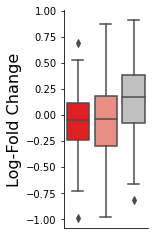

hydroxyfasudil ('PKIA, PRKACA, ROCK1', 'rho associated kinase inhibitor') 0.00039301533814271666 0.03691177080000213


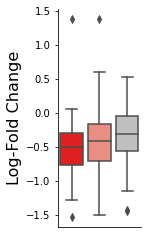

k-strophanthidin ('ATP1A1', 'ATPase inhibitor') 0.0005057180766142782 0.017216304403541494


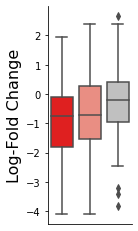

GSK2656157 (nan, 'PERK inhibitor') 0.0038033233529839528 0.017231459270737055


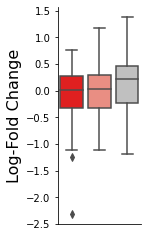

sodium-tanshinone-ii-a-sulfonate (nan, 'potassium channel activator') 0.005132616589299692 0.011334192720692499


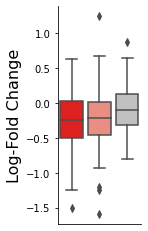

resibufogenin (nan, 'Na/K-ATPase inhibitor') 0.0055954767066841 0.03544523581147489


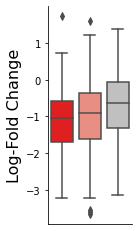

caramiphen ('CHRM1, CHRM2', 'cholinergic receptor antagonist') 0.006137600693740193 0.048794343353083316


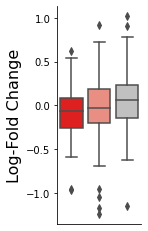

zaleplon ('GABRA1, GABRB1, GABRG2, TSPO', 'benzodiazepine receptor agonist') 0.007910246765978424 0.03955564166515698


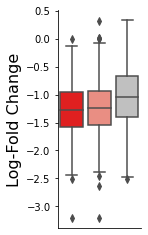

crisaborole ('PDE4B', 'phosphodiesterase inhibitor') 0.009174767957230552 0.03569911837717258


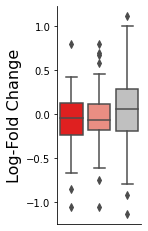

In [48]:
cbaf_p_list = []
cbaf_like_p_list = []
drug_list = []

make_plots = True

for drug_ind in drug_inds2keep:
    drug = filtered_drug_effect.columns[drug_ind]
    
    # cell line LFC
    cbaf_lfc = filtered_drug_effect.loc[cbaf_cell_lines].iloc[:,drug_ind].tolist()
    cbaf_like_lfc = filtered_drug_effect.loc[cbaf_like_cell_lines].iloc[:,drug_ind].tolist()
    no_baf_lfc = filtered_drug_effect.loc[no_baf_cell_lines].iloc[:,drug_ind].tolist()
    
    # differential viability
    cbaf_like_p = ttest_ind(cbaf_like_lfc,no_baf_lfc,nan_policy='omit')[1]
    cbaf_p = ttest_ind(cbaf_lfc,no_baf_lfc,nan_policy='omit')[1]
    
    cbaf_p_list.append(cbaf_p)
    cbaf_like_p_list.append(cbaf_like_p)
    drug_list.append(drug)
        
    if make_plots and cbaf_p < 0.01 and cbaf_like_p < 0.05:

        print(drug,drug_target_dict[drug],cbaf_p,cbaf_like_p)

        lfc = cbaf_lfc + cbaf_like_lfc + no_baf_lfc
        label = ['cBAF mutations']*len(cbaf_cell_lines) + ['cBAF loss-like mutations']*len(cbaf_like_cell_lines) \
                    + ['no BAF mutations']*len(no_baf_cell_lines)
        colors = ['red']*len(cbaf_cell_lines) + ['salmon']*len(cbaf_like_cell_lines) + \
                    ['grey']*len(no_baf_cell_lines)

        plot_df = pd.DataFrame({'lfc': lfc, 'label': label})
        plot_df['group'] = 'all'
        plot_df['colors'] = colors

        plt.figure(figsize=(1.5,4))
        fg = sns.boxplot(x='label',y='lfc',data=plot_df,palette=['red','salmon','silver'])
        sns.despine(right = True, top = True)
        fg.set(xticklabels=[])
        fg.set(xlabel=None)
        fg.tick_params(bottom=False)

        plt.ylabel('Log-Fold Change',fontsize=16)
        plt.show()
    
cbaf_p_list = np.array(cbaf_p_list)
cbaf_like_p_list = np.array(cbaf_like_p_list)
drug_list = np.array(drug_list)

results_df = pd.DataFrame({'drug': drug_list,
             'cBAF p': cbaf_p_list,
             'cBAF-like p': cbaf_like_p_list})

results_df['cBAF -log10p'] = -np.log10(results_df['cBAF p'])
results_df['cBAF-like -log10p'] = -np.log10(results_df['cBAF-like p'])

In [44]:
from scipy.stats import spearmanr,pearsonr

effective_df = results_df[results_df['cBAF p'] < 0.01*100]
print(spearmanr(effective_df['cBAF -log10p'],effective_df['cBAF-like -log10p']))
print(pearsonr(effective_df['cBAF -log10p'],effective_df['cBAF-like -log10p']))

SpearmanrResult(correlation=0.47368421052631576, pvalue=0.04706411117172419)
(0.5463128581642621, 0.018990230851720916)


In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(-np.log10(cbaf_p_list),-np.log10(cbaf_like_p_list),s=100,marker='+')

filtered_results_df = results_df[(results_df['cBAF p'] < 0.05) & (results_df['cBAF-like p'] < 0.05)]
plt.scatter(filtered_results_df['cBAF -log10p'],filtered_results_df['cBAF-like -log10p'],
            s=100,marker='+',color='red')

for drug,x,y in filtered_results_df[['drug','cBAF -log10p','cBAF-like -log10p']].values:
    plt.text(x * (1.01), y * (1.01) , drug, fontsize=12)
    
    
plt.xlabel('cBAF loss\n' r'$-\log_{10}(p)$',fontsize=16)
plt.ylabel('cBAF loss-like\n' r'$-\log_{10}(p)$',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlim([1.8,results_df['cBAF -log10p'].values.max()*1.2])
plt.ylim([results_df['cBAF-like -log10p'].values.min()*0.8,results_df['cBAF-like -log10p'].values.max()*1.2])

sns.despine()
plt.show()